#### 提升方向：
- 止盈和止损点位
- 将RSI window dynamic


#### 止盈设置
- ATR Rachket
- 将止盈从原先的固定0.05变为浮动
     - 持仓周期
     - ATR波动挂钩 
- 观察不同阈值下触及止盈和止损的位置

#### 噪音观察
- 解释DrawBack的原因


In [1]:
import sys
sys.path.append('D:/vnpy_strategies/DoubleRsi')
import numpy as np
import pandas as pd
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from datetime import datetime
from double_rsi_atr import DoubleRsiAtr
from rsi_dollar_atr import RsiDollarATR
from rsi_dollor import RsiDollar
from double_rsi_signal import DoubleSignalGenerator
from trade_by_trade import (calculate_trades_result, generate_trade_df)
import matplotlib.pyplot as plt
import talib

In [ ]:
start_time = datetime(2010, 10, 1)
end_time = datetime(2019, 4, 30)

In [ ]:
strategy_parameters={'s_window':5,'l_window':15,'atr_window':35,'atr_multiplier':0.25,'exit_return_soft_long':-0.1,
                     'obv_window':35,'minus_dm_window':35,'mfi_window':35,'ad_window':35,'adosc_window':35,'plus_dm_window':35,
                     'dx_window':35,'adx_window':35,
                     'exit_loss_soft_long':-0.2,'rsi_window':11,'exit_return_soft_short':0.05,'exit_loss_soft_short':0.3,
                     'long_threshold_l_window': 50, 'long_threshold_s_window':80,'exit_return':0.09,'exit_loss':0.01,'fixed_size':1}


In [ ]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start= start_time,
    end= end_time,
    rate=5/10000,
    slippage=0.6,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(DoubleRsiAtr, strategy_parameters)

In [ ]:
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
summary_dict = engine.calculate_statistics()

In [ ]:
engine.show_chart()

In [ ]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start = start_time,
    end = end_time,
    rate=5/10000,
    slippage=0.6,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(DoubleSignalGenerator, strategy_parameters)
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
summary_dict = engine.calculate_statistics()

In [ ]:
rsi_value_l_window = pd.Series(engine.strategy.rsi_value_recorder_l_window,index=engine.strategy.rsi_time_recorder_l_window)
rsi_value_s_window =pd.Series(engine.strategy.rsi_value_recorder_s_window,index=engine.strategy.rsi_time_recorder_s_window)
atr_value = pd.Series(engine.strategy.atr_value_recorder,index=engine.strategy.atr_time_recorder)
obv_value = pd.Series(engine.strategy.obv_value_recorder,index=engine.strategy.obv_time_recorder)
minus_dm_value = pd.Series(engine.strategy.minus_dm_value_recorder,index=engine.strategy.minus_dm_time_recorder)
mfi_value = pd.Series(engine.strategy.mfi_value_recorder,index=engine.strategy.mfi_time_recorder)
ad_value = pd.Series(engine.strategy.ad_value_recorder,index=engine.strategy.ad_time_recorder)
adosc_value = pd.Series(engine.strategy.adosc_value_recorder,index=engine.strategy.adosc_time_recorder)
plus_dm_value =pd.Series(engine.strategy.plus_dm_value_recorder,index=engine.strategy.plus_dm_time_recorder)
dx_value = pd.Series(engine.strategy.dx_value_recorder,index=engine.strategy.dx_time_recorder)
adx_value = pd.Series(engine.strategy.adx_value_recorder,index=engine.strategy.adx_time_recorder)

In [ ]:
indicator_df = pd.concat([rsi_value_s_window,rsi_value_l_window.reindex(rsi_value_s_window.index,method='ffill'),atr_value,obv_value,
                          minus_dm_value,mfi_value,ad_value,adosc_value,plus_dm_value,dx_value,adx_value],axis=1)
indicator_df.columns = ['rsi_short_window','rsi_long_window','atr','obv','minus_dm','mfi','ad','adosc','plus_dm','dx','adx']
indicator_df.dropna(inplace=True)

### 最大回撤区间
- 2013-2015
- 2016-2017

### 最小回撤区间
- 2011 -2013

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['atr']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['atr']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['atr']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['atr']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['atr']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['atr']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['atr']['2019-01-01':'2019-12-31'],'g-')
plt.legend()
# # ax1.plot(long_accuracy_with_fee,'r-',label='long_side_accuracy')
# ax2.plot(two_pnl_df['close'],'b--',label='close')
# plt.legend()


### Indicator 和 策略 DrawBack
- 将DrawBack分成两个阶段：*Slightly DrawBack，Heavily DrawBack*
    - *RSI* 指标没办法区别这两个*DrawBack* period
    - *ATR* 指标似乎对这两个*DrawBack* period 有一定程度的区分
    

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['rsi_short_window']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['rsi_short_window']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['rsi_short_window']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['rsi_short_window']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['rsi_short_window']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['rsi_short_window']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['rsi_short_window']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['rsi_long_window']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['rsi_long_window']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['rsi_long_window']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['rsi_long_window']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['rsi_long_window']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['rsi_long_window']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['rsi_long_window']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['obv']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['obv']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['obv']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['obv']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['obv']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['obv']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['obv']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['minus_dm']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['minus_dm']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['minus_dm']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['minus_dm']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['minus_dm']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['minus_dm']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['minus_dm']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:

fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['mfi']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['mfi']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['mfi']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['mfi']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['mfi']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['mfi']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['mfi']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:

fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['ad']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['ad']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['ad']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['ad']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['ad']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['ad']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['ad']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['adosc']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['adosc']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['adosc']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['adosc']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['adosc']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['adosc']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['adosc']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['plus_dm']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['plus_dm']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['plus_dm']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['plus_dm']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['plus_dm']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['plus_dm']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['plus_dm']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['dx']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['dx']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['dx']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['dx']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['dx']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['dx']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['dx']['2019-01-01':'2019-12-31'],'g-')
plt.legend()



In [ ]:
fig = plt.figure(figsize=(25,10))

plt.plot(indicator_df['adx']['2011-01-01':'2013-12-31'],'g-',label='slightly_draw_back_period')
plt.plot(indicator_df['adx']['2014-01-01':'2015-01-01'],'r-',label='heavily_draw_back_period')
plt.plot(indicator_df['adx']['2015-01-01':'2015-12-31'],'g-')
plt.plot(indicator_df['adx']['2016-01-01':'2016-12-31'],'r-')
plt.plot(indicator_df['adx']['2017-01-01':'2017-12-31'],'g-')
plt.plot(indicator_df['adx']['2018-01-01':'2018-12-31'],'r-')
plt.plot(indicator_df['adx']['2019-01-01':'2019-12-31'],'g-')
plt.legend()

In [ ]:
np.sum([1,2,3])

In [50]:
start_time = datetime(2015, 1, 1)
end_time = datetime(2016, 9, 30)

In [56]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start = start_time,
    end = end_time,
    rate=5/10000,
    slippage=0.6,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(RsiDollarATR,{'atr_multiplier':1,'cross_over_day':10})
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
summary_dict = engine.calculate_statistics()

2020-04-18 20:07:03.640316	开始加载历史数据
2020-04-18 20:07:03.640316	加载进度： [5%]
2020-04-18 20:07:03.640316	加载进度： [9%]
2020-04-18 20:07:03.640316	加载进度：# [14%]
2020-04-18 20:07:03.640316	加载进度：# [19%]
2020-04-18 20:07:03.640316	加载进度：## [24%]
2020-04-18 20:07:03.640316	加载进度：## [28%]
2020-04-18 20:07:03.640316	加载进度：### [33%]
2020-04-18 20:07:03.640316	加载进度：### [38%]
2020-04-18 20:07:03.640316	加载进度：#### [42%]
2020-04-18 20:07:03.640316	加载进度：#### [47%]
2020-04-18 20:07:03.640316	加载进度：##### [52%]
2020-04-18 20:07:03.640316	加载进度：##### [56%]
2020-04-18 20:07:03.640316	加载进度：###### [61%]
2020-04-18 20:07:03.640316	加载进度：###### [66%]
2020-04-18 20:07:03.640316	加载进度：####### [71%]
2020-04-18 20:07:03.640316	加载进度：####### [75%]
2020-04-18 20:07:03.640316	加载进度：####### [80%]
2020-04-18 20:07:03.640316	加载进度：######## [85%]
2020-04-18 20:07:03.640316	加载进度：######## [89%]
2020-04-18 20:07:03.640316	加载进度：######### [94%]
2020-04-18 20:07:03.640316	加载进度：######### [99%]
2020-04-18 20:07:03.640316	加载进度：########## [100%]


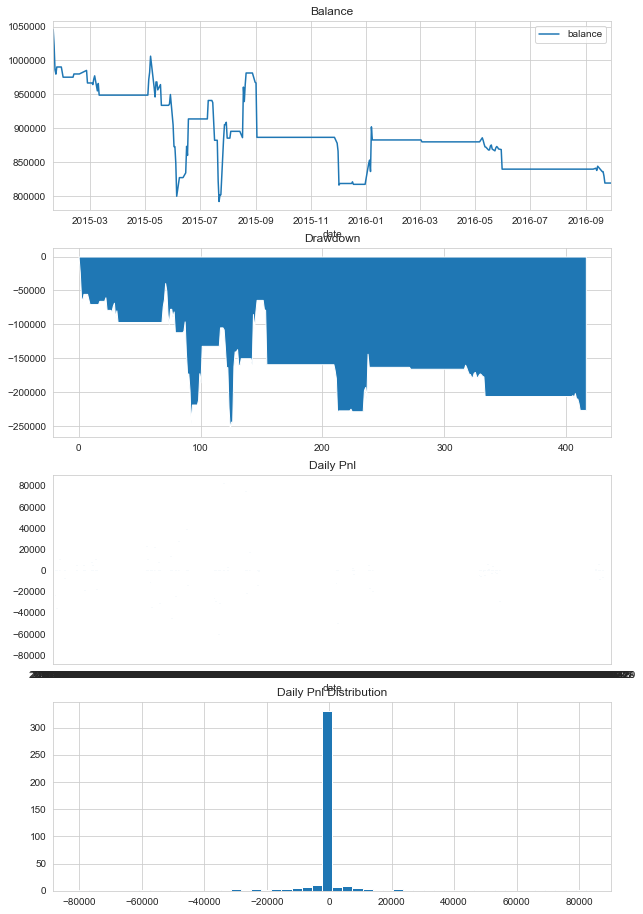

In [52]:
engine.show_chart()

In [53]:
cum_close = pd.Series(engine.strategy.cum_close_list,index=engine.strategy.cum_time_list)
cum_open = pd.Series(engine.strategy.cum_open_list,index=engine.strategy.cum_time_list)
cum_high = pd.Series(engine.strategy.cum_high_list,index=engine.strategy.cum_time_list)
cum_low = pd.Series(engine.strategy.cum_low_list,index=engine.strategy.cum_time_list)
cum_volume = pd.Series(engine.strategy.cum_volume_list,index=engine.strategy.cum_time_list)
cum_df = pd.concat([cum_open,cum_high,cum_low,cum_close,cum_volume],axis = 1)
cum_df.columns = ['open','high','low','close','volume']

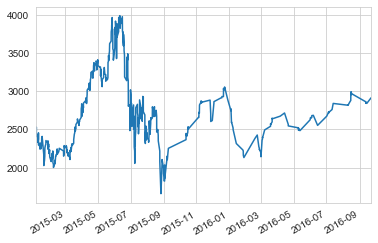

In [54]:
cum_close.plot()

In [55]:
trade_df_with_fee = generate_trade_df(engine.trades,size=300, rate=5/10000, slippage=0.6,capital=100_00_00)
threshold_return = 0
model_accuracy_with_fee = np.sum(trade_df_with_fee['net_pnl']>threshold_return)/trade_df_with_fee['net_pnl'].shape[0]

In [35]:
len(engine.strategy.short_order_record)

15

In [36]:
len(engine.strategy.long_order_record)

14

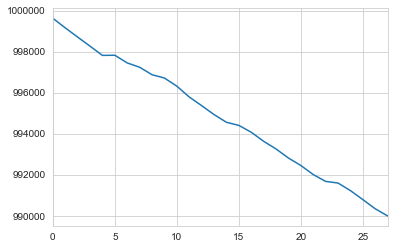

In [33]:
trade_df_with_fee['balance'].plot()

In [34]:
engine.trades['BACKTESTING.1']

TradeData(gateway_name='BACKTESTING', symbol='IF888', exchange=<Exchange.CFFEX: 'CFFEX'>, orderid='1', tradeid='1', direction=<Direction.LONG: '多'>, offset=<Offset.OPEN: '开'>, price=3981.4, volume=1, time='14:39:00')

In [ ]:
engine.strategy.hold_bar_num

In [ ]:
engine.strategy.

In [ ]:
engine.strategy.pos

In [ ]:
trade_df_with_fee['net_pnl'].cumsum().plot()

In [ ]:
cum_df['double_ma_buy']['2018-02-26':]

In [ ]:
cum_df['double_ma_sell']['2018-02-26']

In [ ]:
calculate_trades_result(engine.trades)

In [ ]:
engine.strategy.short_order_record[-1]

In [ ]:
4030

In [ ]:
engine.strategy.short_order_record[-1]*(1-0.02)+3*1*engine.strategy.atr_value

In [ ]:
engine.strategy.atr_value

In [ ]:
engine.strategy.short_order_record[-1]*1.02-200*0.05*engine.strategy.atr_value

In [ ]:
engine.strategy.short_order_record[-1]*1.02+engine.strategy.hold_bar_num*0.05*engine.strategy.atr_value

In [ ]:
(engine.strategy.hold_bar_num+1)*0.05*engine.strategy.atr_value

In [ ]:
engine.strategy.exit_price

In [ ]:
cum_close[-1]

In [ ]:
engine.strategy.hold_bar_num

In [ ]:
cum_close

In [ ]:
trade_df_with_fee

In [ ]:
dollar_close = pd.Series(engine.strategy.close_list,index=engine.strategy.time_list)
dollar_open = pd.Series(engine.strategy.open_list,index=engine.strategy.time_list)
dollar_high = pd.Series(engine.strategy.high_list,index=engine.strategy.time_list)
dollar_low = pd.Series(engine.strategy.low_list,index=engine.strategy.time_list)
dollar_volume = pd.Series(engine.strategy.volume_list,index=engine.strategy.time_list)
dollar_df = pd.concat([dollar_open,dollar_high,dollar_low,dollar_close,dollar_volume],axis = 1)

dollar_df.columns = ['open','high','low','close','volume']

In [ ]:
bb_windows = 14
dollar_df['up'],_,dollar_df['down']=talib.BBANDS(dollar_close,bb_windows)
cum_df['up'],_,cum_df['down']=talib.BBANDS(cum_close,bb_windows)

In [ ]:
rsi_window = 14
rsi_up_threshold = 70
rsi_down_threshold = 30
cum_df['ma5'],cum_df['ma20'] = talib.SMA(cum_close,5),talib.SMA(cum_close,20)
cum_df['double_ma_buy'] = np.where(cum_df['ma5']-cum_df['ma20']>0,1,0)
cum_df['double_ma_sell'] = np.where(cum_df['ma5']-cum_df['ma20']<0,1,0)
cum_df['rsi'] = talib.RSI(cum_close,rsi_window)
cum_df['sell_signal_rsi'] = np.where(cum_df['rsi']>rsi_up_threshold,1,0)
cum_df['buy_signal_rsi'] = np.where(cum_df['rsi']<rsi_down_threshold,1,0)


In [ ]:
cum_df[['close','buy_signal_rsi']].plot(secondary_y='close',figsize=(25,10),alpha=0.5)

In [ ]:
cum_df[['close','double_ma_buy']].plot(secondary_y='close',figsize=(25,10),alpha=0.5)

In [ ]:
cum_df[['close','double_ma_sell']].plot(secondary_y='close',figsize=(25,10),alpha=0.5)

In [ ]:
3000*0.02/(68*0.05)

In [ ]:
talib.ATR(cum_high,cum_low,cum_close).describe()

In [ ]:
cum_df['rsi'].describe()

In [ ]:
cum_df[['close','buy_signal','sell_signal']].plot(secondary_y='close',figsize=(25,10))


In [ ]:
dollar_df[['close']].plot(figsize=(25,10))

In [ ]:
dollar_df['2010-10-14'].index

In [ ]:
engine.strategy.long_trend_cum

In [ ]:
dollar_df.sort_values('close',ascending=True)


In [57]:
talib.CCI?

In [ ]:
rsi_value_l_window = pd.Series(engine.strategy.rsi_value_recorder_l_window,index=engine.strategy.rsi_time_recorder_l_window)
rsi_value_s_window =pd.Series(engine.strategy.rsi_value_recorder_s_window,index=engine.strategy.rsi_time_recorder_s_window)
atr_value = pd.Series(engine.strategy.atr_value_recorder,index=engine.strategy.atr_time_recorder)
obv_value = pd.Series(engine.strategy.obv_value_recorder,index=engine.strategy.obv_time_recorder)
minus_dm_value = pd.Series(engine.strategy.minus_dm_value_recorder,index=engine.strategy.minus_dm_time_recorder)
mfi_value = pd.Series(engine.strategy.mfi_value_recorder,index=engine.strategy.mfi_time_recorder)
ad_value = pd.Series(engine.strategy.ad_value_recorder,index=engine.strategy.ad_time_recorder)
adosc_value = pd.Series(engine.strategy.adosc_value_recorder,index=engine.strategy.adosc_time_recorder)
plus_dm_value =pd.Series(engine.strategy.plus_dm_value_recorder,index=engine.strategy.plus_dm_time_recorder)
dx_value = pd.Series(engine.strategy.dx_value_recorder,index=engine.strategy.dx_time_recorder)
adx_value = pd.Series(engine.strategy.adx_value_recorder,index=engine.strategy.adx_time_recorder)